In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import transform

import numpy as np
import glob
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

In [2]:
emotion = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}

In [3]:
NUM_CLASSES = 10

In [4]:
class FaceEmotionDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.images_path = []

        for f in glob.glob(root_dir+'/**/*.jpg', recursive=True):
            self.images_path.append(os.path.normpath(f))


    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = plt.imread(self.images_path[idx])
        cat = int(os.path.basename(self.images_path[idx]).split('-')[0])

        sample = {'image': image, 'cat':cat}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'cat': sample['cat']}

class CenterCrop(object):
    """Crop the image at the center.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = (h - new_h) // 2
        left = (w - new_w) // 2

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'cat': sample['cat']}

class RandomCrop(CenterCrop):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        super(RandomCrop, self).__init__(output_size)

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'cat': sample['cat']}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'cat': torch.tensor(sample['cat'])} 

In [6]:
folder_path = '/home/studenti/ballerini/datasets/RAVDESS_frames'

IMG_SIZE = 128

face_dataset = FaceEmotionDataset(root_dir=folder_path,
                                    transform=transforms.Compose([
                                        Rescale(IMG_SIZE), 
                                        CenterCrop(IMG_SIZE), 
                                        ToTensor()
                                    ]))               

In [7]:
trainingset_len = len(face_dataset) // 100 * 90
testset_len = len(face_dataset) - trainingset_len

print('training set size: ',trainingset_len)
print('test set size: ',testset_len)

training set size:  3870
test set size:  450


In [8]:
train_set, test_set = torch.utils.data.random_split(face_dataset, [trainingset_len,testset_len])

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show the images
def imageshow(sample):
    plt.imshow(sample['image'].permute(1, 2, 0))
    print(emotion[sample['cat'].item()])

calm


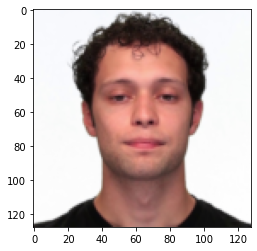

In [10]:
idx = 0

imageshow(train_set[idx])

In [11]:
trainloader = DataLoader(train_set, batch_size=128,
                        shuffle=True, num_workers=16)

testloader = DataLoader(test_set, batch_size=128,
                        shuffle=True, num_workers=16)

In [12]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2)
        )
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2)
        )
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
        )
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
        )
        
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2)
        )
        
        self.layer6 = torch.nn.Sequential(
            nn.Linear(16*(IMG_SIZE//4)*(IMG_SIZE//4), 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        
        self.layer7 = torch.nn.Sequential(
            nn.Linear(200, 200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        
        self.layer8 = torch.nn.Sequential(
            nn.Linear(200, 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5)
        )
        
        self.layer9 = torch.nn.Sequential(
            nn.Linear(100, NUM_CLASSES)
        )
        

    def forward(self, input):
        output = self.layer1(input)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = self.layer5(output)
        output = output.view(-1, 16*(IMG_SIZE//4)*(IMG_SIZE//4))
        output = self.layer6(output)
        output = self.layer7(output)
        output = self.layer8(output)
        output = self.layer9(output)
        return output

# Instantiate a neural network model 
model = Network().double()

# Define your execution device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
model.to(device)

The model will be running on cuda:0 device


Network(
  (layer1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer4): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm2d(16, eps=1e-05,

In [13]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [14]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    
    with torch.no_grad():
        for sample in testloader:
            images = Variable(sample['image'].to(device))
            labels = Variable(sample['cat'].to(device))
            
            outputs = model(images)
            running_loss += loss_fn(outputs, labels).item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    accuracy = (100 * accuracy / total)
    running_loss = (100 * running_loss / total)
    return(accuracy, running_loss)


def train(num_epochs):
    training_loss = []
    test_loss = []
    
    best_accuracy = 0.0
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        running_acc = 0.0
        total = 0.0

        for i, sample in enumerate(trainloader):
            images = Variable(sample['image'].to(device))
            labels = Variable(sample['cat'].to(device))

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total += labels.size(0)
            running_loss += loss.item()
            
        training_loss.append(running_loss * 100 / total)

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy, test_loss_epoch = testAccuracy()
        test_loss.append(test_loss_epoch)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # save the model if the accuracy is the best
        '''if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy'''
            
    return training_loss, test_loss

In [ ]:

N_EPOCHS = 20
training_loss, test_loss = train(N_EPOCHS)
print('Finished Training')
# Test which classes performed well
#testModelAccuracy()

# Let's load the model we just created and test the accuracy per label
# model = Network()
# path = "myFirstModel.pth"
# model.load_state_dict(torch.load(path))

# Test with batch of images
# testBatch()

  5%|███▌                                                                  | 1/20 [01:10<22:20, 70.57s/it]

For epoch 1 the test accuracy over the whole test set is 12 %



 10%|███████                                                               | 2/20 [02:24<21:42, 72.36s/it]

For epoch 2 the test accuracy over the whole test set is 19 %



 15%|██████████▌                                                           | 3/20 [03:35<20:18, 71.67s/it]

For epoch 3 the test accuracy over the whole test set is 28 %



 20%|██████████████                                                        | 4/20 [04:46<19:05, 71.59s/it]

For epoch 4 the test accuracy over the whole test set is 27 %



 25%|█████████████████▌                                                    | 5/20 [05:57<17:48, 71.25s/it]

For epoch 5 the test accuracy over the whole test set is 42 %



 30%|█████████████████████                                                 | 6/20 [07:10<16:46, 71.90s/it]

For epoch 6 the test accuracy over the whole test set is 49 %



 35%|████████████████████████▌                                             | 7/20 [08:20<15:27, 71.37s/it]

For epoch 7 the test accuracy over the whole test set is 60 %



 40%|████████████████████████████                                          | 8/20 [09:31<14:16, 71.38s/it]

For epoch 8 the test accuracy over the whole test set is 62 %



 45%|███████████████████████████████▌                                      | 9/20 [10:43<13:06, 71.52s/it]

For epoch 9 the test accuracy over the whole test set is 70 %



 50%|██████████████████████████████████▌                                  | 10/20 [11:54<11:53, 71.35s/it]

For epoch 10 the test accuracy over the whole test set is 72 %



 55%|█████████████████████████████████████▉                               | 11/20 [13:05<10:40, 71.15s/it]

For epoch 11 the test accuracy over the whole test set is 75 %



 60%|█████████████████████████████████████████▍                           | 12/20 [14:19<09:35, 71.99s/it]

For epoch 12 the test accuracy over the whole test set is 75 %


In [ ]:
epochs = range(0, N_EPOCHS)
plt.plot(epochs, training_loss, 'g', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()